In [1]:
import os
os.chdir("..")

In [2]:
from SSTImportanceSampling import Preprocessor, ImportanceSampler,StormDepthProcessor

In [3]:
trinity = Preprocessor.load("/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity")

In [ ]:
from __future__ import annotations

import math
from typing import Tuple

import geopandas as gpd
import numpy as np
from shapely.geometry import box, Polygon, Point
from shapely.ops import triangulate
from shapely.prepared import prep


def _cell_size_from_target_cells(domain: gpd.GeoDataFrame, target_cells: int) -> float:
    """
    Pick square cell size so total number of cells ≈ target_cells after clipping.
    Assumes domain is in a projected CRS (meters). Returns edge length in meters.
    """
    if domain.crs is None:
        raise ValueError("Domain GeoDataFrame must have a projected CRS set.")
    A = float(domain.geometry.area.sum())  # m^2
    A_cell = A / max(target_cells, 1)
    return math.sqrt(A_cell)  # meters


def _square_grid_over_bbox(bounds: Tuple[float, float, float, float], cell: float):
    """
    Generate axis-aligned square boxes that tile the bounding box.
    """
    minx, miny, maxx, maxy = bounds
    xs = np.arange(minx, maxx + cell, cell)
    ys = np.arange(miny, maxy + cell, cell)
    for x in xs[:-1]:
        for y in ys[:-1]:
            yield box(x, y, x + cell, y + cell)


def make_initial_grid(
    domain: gpd.GeoDataFrame,
    target_cells: int = 96,
    sliver_fraction: float = 0.20,
    keep_columns: Tuple[str, ...] = (),
) -> gpd.GeoDataFrame:
    """
    Create the initial clipped square grid over an irregular domain.

    Parameters
    ----------
    domain : gpd.GeoDataFrame
        Single-row (or dissolved) polygon GeoDataFrame in a projected CRS.
    target_cells : int
        Rough target number of cells (64–96 is a good start).
    sliver_fraction : float
        Drop/merge cells with area < sliver_fraction * mean_cell_area (before clipping).
    keep_columns : tuple of str
        Optional domain attribute columns to carry over.

    Returns
    -------
    grid : gpd.GeoDataFrame
        Columns: grid_id, level, area_m2, pi_init, geometry
    """
    # Dissolve domain to one polygon if needed
    dom = domain[[*keep_columns, "geometry"]].copy()
    if len(dom) > 1:
        dom = dom.dissolve().reset_index(drop=True)

    # Compute cell size and build raw grid
    cell = _cell_size_from_target_cells(dom, target_cells)
    grid_boxes = list(_square_grid_over_bbox(dom.total_bounds, cell))
    grid = gpd.GeoDataFrame(geometry=grid_boxes, crs=dom.crs)

    # Clip to domain polygon (keeps irregular boundary)
    grid = gpd.overlay(grid, dom[["geometry"]], how="intersection", keep_geom_type=True)
    grid = grid[~grid.is_empty].reset_index(drop=True)

    # Compute areas and drop/merge slivers (simple drop here; merge can be added later)
    A_total = float(dom.geometry.area.sum())
    A_cell_mean = (cell * cell)  # mean area pre-clip
    min_area = sliver_fraction * A_cell_mean

    grid["area_m2"] = grid.geometry.area
    grid = grid.loc[grid["area_m2"] > min_area].reset_index(drop=True)

    # Initialize probabilities proportional to clipped area (so q == p in iter 1)
    grid["pi_init"] = grid["area_m2"] / A_total

    # Basic identifiers
    grid.insert(0, "grid_id", np.arange(1, len(grid) + 1, dtype=int))
    grid["level"] = 1  # refinement level = 1 for initial grid

    # Tidy sort (largest first can help with refinement bookkeeping)
    grid = grid.sort_values("area_m2", ascending=False).reset_index(drop=True)
    grid["grid_id"] = np.arange(1, len(grid) + 1, dtype=int)

    return grid


# ---- Optional: uniform sampling inside a polygon (for later) ----

def _sample_point_in_triangle(tri: Polygon) -> Point:
    """
    Uniform sample inside a triangle using barycentric coordinates.
    """
    (x1, y1), (x2, y2), (x3, y3) = np.asarray(tri.exterior.coords)[:3]
    r1, r2 = np.random.rand(2)
    sqrt_r1 = math.sqrt(r1)
    u = 1.0 - sqrt_r1
    v = sqrt_r1 * (1.0 - r2)
    w = sqrt_r1 * r2
    x = u * x1 + v * x2 + w * x3
    y = u * y1 + v * y2 + w * y3
    return Point(x, y)


def sample_uniform_in_polygon(poly: Polygon, n: int = 1) -> list[Point]:
    """
    Draw n points uniformly from an arbitrary (possibly concave) polygon by
    area-weighted triangle sampling.
    """
    tris = triangulate(poly)
    areas = np.array([t.area for t in tris], dtype=float)
    probs = areas / areas.sum()
    idx = np.random.choice(len(tris), size=n, p=probs)
    return [_sample_point_in_triangle(tris[i]) for i in idx]


In [5]:
# domain_gdf should be a single dissolved polygon in your SHG/equal-area CRS
# Example:
# domain_gdf = gpd.read_file("transposition_domain.gpkg").to_crs("EPSG:5070")  # if needed

grid_gdf = make_initial_grid(
    domain= trinity.domain_gdf,
    target_cells=50,      # try 64–96 to start
    sliver_fraction=0.20  # drop very tiny clipped slivers
)

# Initialize storm-conditional to uniform (1/440) if you want to store it separately
n_storms = 440
rho_uniform = 1.0 / n_storms  # if you later keep per-cell storm conditionals

grid_gdf.head()

,grid_id,geometry,area_m2,pi_init,level
0,1,"POLYGON ((-179418.228 958061.909, -179418.228 ...",1.839504e+10,0.02,1
1,2,"POLYGON ((91838.388 1093690.217, 91838.388 122...",1.839504e+10,0.02,1
2,3,"POLYGON ((-43789.92 1093690.217, -43789.92 122...",1.839504e+10,0.02,1
3,4,"POLYGON ((-43789.92 958061.909, -43789.92 1093...",1.839504e+10,0.02,1
4,5,"POLYGON ((91838.388 958061.909, 91838.388 1093...",1.839504e+10,0.02,1


In [ ]:
grid_gdf

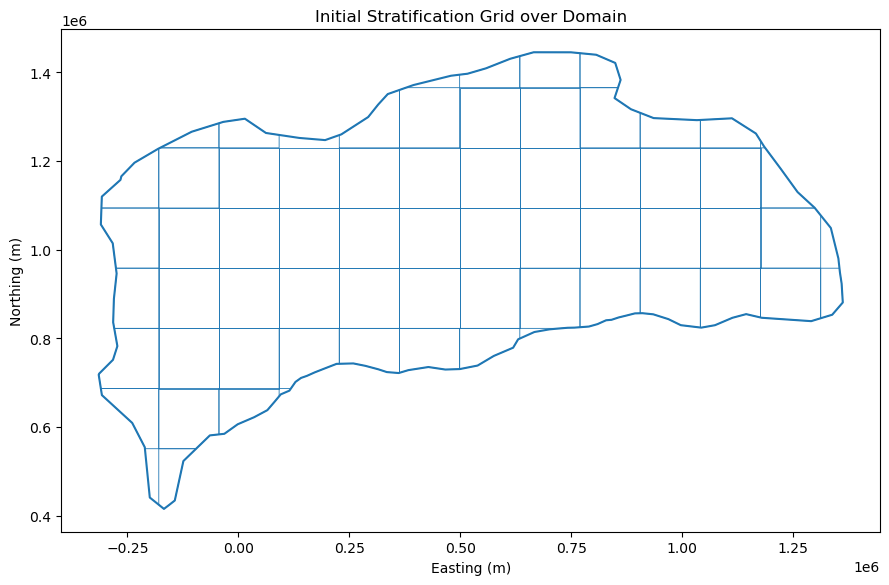

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Quick sanity check: same CRS ---
assert trinity.domain_gdf.crs == grid_gdf.crs, "domain_gdf and grid_gdf must share the same CRS"

# --- Basic overlay plot (domain outline + grid) ---
fig, ax = plt.subplots(figsize=(9, 9))
trinity.domain_gdf.boundary.plot(ax=ax, linewidth=1.5)
grid_gdf.boundary.plot(ax=ax, linewidth=0.6)

ax.set_aspect("equal")
ax.set_title("Initial Stratification Grid over Domain")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [143]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from affine import Affine
from joblib import Parallel, delayed
from shapely.geometry import Point, Polygon, box, mapping
from shapely.ops import triangulate
from rasterio.features import geometry_mask
from shapely.prepared import prep

# ---------------------------
# 1) Geometry & grid helpers
# ---------------------------

def _cell_size_from_target_cells(domain: gpd.GeoDataFrame, target_cells: int) -> float:
    """Return square cell edge-length (meters) so total cells ≈ target_cells after clipping."""
    if domain.crs is None:
        raise ValueError("domain GeoDataFrame must have a projected (equal-area) CRS.")
    A = float(domain.geometry.area.sum())
    A_cell = A / max(target_cells, 1)
    return math.sqrt(A_cell)


def _square_grid_over_bbox(bounds: Tuple[float, float, float, float], cell: float) -> Iterable[Polygon]:
    """Generate axis-aligned square polygons that tile the bounding box."""
    minx, miny, maxx, maxy = bounds
    xs = np.arange(minx, maxx + cell, cell)
    ys = np.arange(miny, maxy + cell, cell)
    for x in xs[:-1]:
        for y in ys[:-1]:
            yield box(x, y, x + cell, y + cell)


def make_initial_grid(
    domain: gpd.GeoDataFrame,
    target_cells: int = 96,
    sliver_fraction: float = 0.20,
) -> gpd.GeoDataFrame:
    """
    Create a clipped square grid over an irregular domain polygon.

    Returns a GeoDataFrame with columns:
      - grid_id (int)
      - level (int)
      - area_m2 (float)
      - pi (float)   # cell probability for iteration 1 (area-proportional)
      - geometry (Polygon)
    """
    dom = domain[["geometry"]].copy()
    if len(dom) > 1:
        dom = dom.dissolve().reset_index(drop=True)

    cell = _cell_size_from_target_cells(dom, target_cells)
    raw = gpd.GeoDataFrame(geometry=list(_square_grid_over_bbox(dom.total_bounds, cell)), crs=dom.crs)
    grid = gpd.overlay(raw, dom, how="intersection", keep_geom_type=True)
    grid = grid[~grid.is_empty].reset_index(drop=True)

    A_total = float(dom.geometry.area.sum())
    A_cell_mean_preclip = cell * cell
    min_area = sliver_fraction * A_cell_mean_preclip

    grid["area_m2"] = grid.geometry.area
    grid = grid.loc[grid["area_m2"] > min_area].reset_index(drop=True)

    grid.insert(0, "grid_id", np.arange(1, len(grid) + 1, dtype=int))
    grid["level"] = 1
    grid["pi"] = grid["area_m2"] / A_total

    # stable ordering
    grid = grid.sort_values("area_m2", ascending=False).reset_index(drop=True)
    grid["grid_id"] = np.arange(1, len(grid) + 1, dtype=int)
    return grid


def _sample_point_in_triangle(tri: Polygon) -> Point:
    """Uniform sample inside a triangle via barycentric coords."""
    (x1, y1), (x2, y2), (x3, y3) = np.asarray(tri.exterior.coords)[:3]
    r1, r2 = np.random.rand(2)
    sr1 = math.sqrt(r1)
    u = 1.0 - sr1
    v = sr1 * (1.0 - r2)
    w = sr1 * r2
    return Point(u * x1 + v * x2 + w * x3, u * y1 + v * y2 + w * y3)


def sample_uniform_in_polygon(poly, n: int = 1):
    """
    Robust uniform sampling inside an arbitrary polygon (handles holes, concavity).
    Uses rejection sampling in the polygon's bounding box.
    """
    minx, miny, maxx, maxy = poly.bounds
    prepped = prep(poly)
    pts = []
    need = n

    # oversample batches to keep it efficient
    while need > 0:
        k = max(32, 3 * need)  # batch size
        xs = np.random.uniform(minx, maxx, size=k)
        ys = np.random.uniform(miny, maxy, size=k)
        for x, y in zip(xs, ys):
            p = Point(x, y)
            if prepped.covers(p):   # strictly inside (covers handles boundary nicely)
                pts.append(p)
                need -= 1
                if need == 0:
                    break
    return pts

# ---------------------------
# Quadtree refinement helpers
# ---------------------------

def _split_cell_into_quads(cell_row: gpd.GeoSeries, crs) -> gpd.GeoDataFrame:
    poly = cell_row.geometry
    minx, miny, maxx, maxy = poly.bounds
    mx = 0.5 * (minx + maxx)
    my = 0.5 * (miny + maxy)

    quads = [
        box(minx, miny, mx,    my),
        box(mx,   miny, maxx,  my),
        box(minx, my,   mx,    maxy),
        box(mx,   my,   maxx,  maxy),
    ]

    geoms = []
    for q in quads:
        piece = poly.intersection(q)
        if not piece.is_empty:
            geoms.append(piece)

    # use the **parent CRS**, not polygon.crs
    gdf = gpd.GeoDataFrame(geometry=geoms, crs=crs).reset_index(drop=True)
    return gdf


def refine_grid_quadtree(
    grid: gpd.GeoDataFrame,
    stats: pd.DataFrame,
    top_k: int = 3,
    min_child_area_frac: float = 0.05,
    focus_poly: Optional[Polygon] = None,
    min_tail_n: int = 3,
) -> gpd.GeoDataFrame:
    # if no stats or no sigma, nothing to refine
    if stats is None or stats.empty or ("sigma" not in stats.columns):
        return grid.copy()

    g = grid.copy()
    g["geometry"] = g.geometry.buffer(0)

    s = stats.set_index("grid_id")
    # merge whatever we have: sigma (required) and n (optional)
    merge_cols = [c for c in ["sigma", "n"] if c in s.columns]
    g = g.merge(s[merge_cols], left_on="grid_id", right_index=True, how="left")

    # fill defaults
    g["sigma"] = g["sigma"].fillna(0.0)
    if "n" not in g.columns:
        g["n"] = 0
    else:
        g["n"] = g["n"].fillna(0).astype(int)

    # optional: only consider cells with enough tail samples
    if min_tail_n is not None and min_tail_n > 0:
        g = g.loc[g["n"] >= min_tail_n]

    # optional: restrict to focus zone
    if focus_poly is not None:
        g = g.loc[g.geometry.intersects(focus_poly)]

    if g.empty:
        return grid.copy()

    # variance-contribution proxy
    A_total = float(g["area_m2"].sum())
    g["var_contrib"] = (g["area_m2"] / A_total) ** 2 * (g["sigma"] ** 2)

    to_split = g.sort_values("var_contrib", ascending=False).head(top_k)
    if to_split.empty:
        return grid.copy()

    keep = grid.loc[~grid["grid_id"].isin(to_split["grid_id"])].copy()
    childs = []
    crs0 = grid.crs
    next_level_default = (int(grid["level"].max()) if "level" in grid.columns else 1) + 1

    for _, row in to_split.iterrows():
        parent_area = float(row["area_m2"])
        parent_pi   = float(row["pi"])
        parent_lvl  = int(row["level"]) + 1 if "level" in grid.columns else next_level_default

        kids = _split_cell_into_quads(row, crs=crs0)
        if kids.empty:
            keep = pd.concat([keep, row.to_frame().T], ignore_index=True)
            continue

        kids["area_m2"] = kids.geometry.area
        min_child_area = min_child_area_frac * (parent_area / 4.0)
        kids = kids.loc[kids["area_m2"] >= min_child_area].reset_index(drop=True)
        if kids.empty:
            keep = pd.concat([keep, row.to_frame().T], ignore_index=True)
            continue

        share = kids["area_m2"] / kids["area_m2"].sum()
        kids["pi"] = parent_pi * share
        kids["level"] = parent_lvl
        childs.append(kids[["geometry", "area_m2", "pi", "level"]])

    if not childs:
        return grid.copy()

    children_gdf = pd.concat(childs, ignore_index=True)
    new_grid = pd.concat(
        [keep[["geometry", "area_m2", "pi", "level"]] if "level" in keep.columns else keep[["geometry", "area_m2", "pi"]],
         children_gdf],
        ignore_index=True,
    )
    new_grid["pi"] = new_grid["pi"] / new_grid["pi"].sum()
    new_grid = new_grid.sort_values("area_m2", ascending=False).reset_index(drop=True)
    new_grid.insert(0, "grid_id", np.arange(1, len(new_grid) + 1, dtype=int))
    new_grid = new_grid.set_crs(crs0, allow_override=True)
    return new_grid




# --------------------------------------------
# 2) Simple precipitation-depths processor
# --------------------------------------------

class StormDepthProcessorSimple:
    """
    Compute watershed-averaged precipitation depth for sampled (x, y) + chosen storm.
    Expects a preprocessed cube with dims (storm_path, y, x) and a watershed polygon mask.
    """

    def __init__(
        self,
        precip_cube: xr.DataArray,
        storm_centers: pd.DataFrame,  # columns: ['storm_path','x','y'] in same CRS
        watershed_gdf: gpd.GeoDataFrame,
    ) -> None:
        self.cube = precip_cube
        self.storm_centers = storm_centers.set_index("storm_path")
        self.x_coords = precip_cube.x.values
        self.y_coords = precip_cube.y.values
        self.dx = float(np.mean(np.diff(self.x_coords)))
        self.dy = float(np.mean(np.diff(self.y_coords)))
        self.transform = Affine.translation(self.x_coords[0], self.y_coords[0]) * Affine.scale(self.dx, self.dy)

        self.mask = geometry_mask(
            geometries=[mapping(geom) for geom in watershed_gdf.geometry],
            out_shape=(len(self.y_coords), len(self.x_coords)),
            transform=self.transform,
            invert=True,
        )

        if "storm_path" not in precip_cube.dims:
            raise ValueError("precip_cube must have a 'storm_path' dimension.")

    def _shift_and_avg(self, storm_path: str, x_new: float, y_new: float) -> float:
        # original storm center
        try:
            x0, y0 = self.storm_centers.loc[storm_path, ["x", "y"]]
        except KeyError:
            return np.nan

        dx_cells = int(round((x_new - x0) / self.dx))
        dy_cells = int(round((y_new - y0) / self.dy))

        sp_idx = int(np.where(self.cube.storm_path.values == storm_path)[0][0])
        precip = self.cube.isel(storm_path=sp_idx).values  # 2D (y,x)

        shifted = np.roll(precip, shift=(dy_cells, dx_cells), axis=(0, 1))

        # zero-fill wrapped edges
        if dy_cells > 0:
            shifted[:dy_cells, :] = 0
        elif dy_cells < 0:
            shifted[dy_cells:, :] = 0
        if dx_cells > 0:
            shifted[:, :dx_cells] = 0
        elif dx_cells < 0:
            shifted[:, dx_cells:] = 0

        # mask watershed & average
        masked = np.where(self.mask, shifted, 0.0)
        masked = np.where(np.isnan(masked), 0.0, masked)
        return float(masked.sum() / self.mask.sum())

    def compute_depths(
        self,
        samples: pd.DataFrame,  # columns: ['event_id','x','y','storm_path']
        n_jobs: int = -1,
    ) -> pd.DataFrame:
        """Return a DataFrame with columns: event_id, x, y, storm_path, precip_avg_mm."""
        tasks = list(
            zip(samples["event_id"].tolist(), samples["storm_path"].tolist(), samples["x"].tolist(), samples["y"].tolist())
        )

        def _one(ev_id: str, sp: str, x: float, y: float) -> Dict[str, object]:
            pavg = self._shift_and_avg(sp, x, y)
            return {"event_id": ev_id, "x": x, "y": y, "storm_path": sp, "precip_avg_mm": pavg}

        if n_jobs == 1:
            out = [_one(*t) for t in tasks]
        else:
            out = Parallel(n_jobs=n_jobs, prefer="threads")([delayed(_one)(*t) for t in tasks])

        return pd.DataFrame(out)


# ---------------------------------------------------
# 3) Adaptive stratified IS for precipitation depth
# ---------------------------------------------------

@dataclass
class Partition:
    """Holds a grid (GeoDataFrame), with lookup helpers."""
    grid: gpd.GeoDataFrame  # columns: grid_id, area_m2, pi, geometry
    sindex: object          # spatial index for point→cell lookup
    areas: Dict[int, float] # grid_id → area
    pis: Dict[int, float]   # grid_id → pi (cell prob)

    @classmethod
    def from_grid(cls, grid_gdf: gpd.GeoDataFrame) -> "Partition":
        grid = grid_gdf[["grid_id", "area_m2", "pi", "geometry"]].copy()
        sindex = grid.sindex
        areas = dict(zip(grid["grid_id"].tolist(), grid["area_m2"].astype(float).tolist()))
        pis = dict(zip(grid["grid_id"].tolist(), grid["pi"].astype(float).tolist()))
        return cls(grid=grid, sindex=sindex, areas=areas, pis=pis)

    def locate_cell_id(self, x: float, y: float) -> Optional[int]:
        pt = Point(x, y)
        for idx in list(self.sindex.query(pt)):
            geom = self.grid.iloc[idx].geometry
            if geom.covers(pt):      # fixes boundary misses (fewer empty stats)
                return int(self.grid.iloc[idx]["grid_id"])
        return None


class AdaptiveDepthSIS:
    """
    Adaptive stratified importance sampling for precipitation depths (uniform target in space × storms).
    Uses AMIS to reuse all evaluations across iterations.
    """

    def __init__(
        self,
        domain_gdf: gpd.GeoDataFrame,
        processor: StormDepthProcessorSimple,
        storm_paths: np.ndarray,          # 1D array of storm_path labels
        target_cells: int = 96,
        pi_floor: float = 1e-3,           # minimum per-cell probability
        storm_floor: float = 0.0,         # we keep storm choice uniform; floor unused
        rng: Optional[np.random.Generator] = None,
        adapt_min_depth_mm: float = 2.0 * 25.4,
    ) -> None:
        self.domain = domain_gdf[["geometry"]].copy()
        self.grid0 = make_initial_grid(domain_gdf, target_cells=target_cells)
        self.partitions: List[Partition] = [Partition.from_grid(self.grid0)]
        self.processor = processor
        self.storm_paths = storm_paths
        self.n_storms = int(storm_paths.size)
        self.pi_floor = float(pi_floor)
        self.rng = rng or np.random.default_rng(1234)
        self.adapt_min_depth_mm = float(adapt_min_depth_mm)
        
        # constants for the target density p(x,s) = 1/A * 1/|S|
        self.A_total = float(self.domain.geometry.area.sum())
        self.p_storm = 1.0 / self.n_storms
        self.p_target_const = (1.0 / self.A_total) * self.p_storm

        # storage
        self.samples_all: pd.DataFrame = pd.DataFrame()  # all iterations
        self.iter_meta: List[Dict[str, float]] = []      # batch sizes, etc.

    # ---------- sampling helpers ----------

    def _allocate_counts(self, grid, n_total, weighted_stats=None, blend_area: float = 0.3) -> pd.DataFrame:
        g = grid[["grid_id", "area_m2", "pi", "geometry"]].copy()

        area = g["area_m2"].to_numpy(dtype=float)
        area_prob = area / max(area.sum(), 1e-300)

        use_area_only = (weighted_stats is None) or weighted_stats.empty or ("sigma" not in weighted_stats.columns)
        if not use_area_only:
            stats = weighted_stats.set_index("grid_id")
            sig = g["grid_id"].map(stats["sigma"]).to_numpy(dtype=float)
            sig[~np.isfinite(sig)] = 0.0
            neyman = area * sig
            total = neyman.sum()
            if not np.isfinite(total) or total <= 0:
                use_area_only = True
            else:
                neyman = neyman / total
                probs = blend_area * area_prob + (1.0 - blend_area) * neyman
        if use_area_only:
            probs = area_prob

        # floors & normalization
        probs = np.asarray(probs, dtype=float)
        probs[~np.isfinite(probs)] = 0.0
        probs = np.maximum(probs, self.pi_floor)
        s = probs.sum()
        probs = (np.ones_like(probs) / len(probs)) if s <= 0 else (probs / s)

        # integer allocation
        ideal = probs * n_total
        n_alloc = np.floor(ideal).astype(int)
        short = int(n_total - n_alloc.sum())
        if short > 0:
            frac = ideal - np.floor(ideal)
            n_alloc[np.argsort(-frac)[:short]] += 1

        g["n_alloc"] = n_alloc
        # IMPORTANT: set the π used for q_draw to the realized fraction this iteration
        g["pi"] = n_alloc / max(n_total, 1)          # <-- add/update π_c^(t)

        return g


    def _sample_points_in_cells(self, grid_alloc: gpd.GeoDataFrame) -> pd.DataFrame:
        """Sample uniform points inside each cell according to 'n_alloc'."""
        rows = []
        for _, row in grid_alloc.iterrows():
            n = int(row["n_alloc"])
            if n <= 0:
                continue
            pts = sample_uniform_in_polygon(row.geometry, n=n)
            for p in pts:
                rows.append(
                    {
                        "grid_id": int(row["grid_id"]),
                        "x": float(p.x),
                        "y": float(p.y),
                        # proposal density piece for this iteration (space part only)
                        "A_c": float(row["area_m2"]),
                        "pi_c": float(row["pi"]),
                    }
                )
        return pd.DataFrame(rows)

    # ---------- AMIS weighting ----------

    def _q_iter(self, part: Partition, x: float, y: float) -> float:
        """q_t(x,s) for a specific iteration t (uniform storms)."""
        gid = part.locate_cell_id(x, y)
        if gid is None:
            return 0.0
        pi_c = part.pis[gid]
        A_c = part.areas[gid]
        return pi_c * (1.0 / A_c) * self.p_storm  # piecewise uniform × uniform storm

    def _qbar(self, coords: np.ndarray) -> np.ndarray:
        """
        Mixture proposal density over all iterations used so far.
        coords: array of shape (N, 2) with columns [x, y].
        """
        N = coords.shape[0]
        # equal-weight mixture by total draws (deterministic mixture)
        n_per_iter = np.array([m["n_total"] for m in self.iter_meta], dtype=float)
        Ntot = float(n_per_iter.sum())
        weights = n_per_iter / Ntot

        qsum = np.zeros(N, dtype=float)
        for w, part in zip(weights, self.partitions):
            # evaluate per-sample q_t
            q_t = np.array([self._q_iter(part, coords[i, 0], coords[i, 1]) for i in range(N)], dtype=float)
            qsum += w * q_t
        return qsum

    # ---------- public API ----------

    def run(
        self,
        n_iters: int,
        batch_schedule: List[int],
        blend_area: float = 0.3,
        n_jobs: int = -1,
        seed: Optional[int] = 1234,
        refine_at: Optional[Dict[int, int]] = None,
        weight_mode: str = "amis", 
        adapt_min_depth_inches: Optional[float] = None, 
    ) -> pd.DataFrame:
        """
        Run n_iters of adaptive stratified sampling for depths.
        Returns a DataFrame with all samples and IS weights.
        """
        EPS = np.finfo(float).tiny
        if adapt_min_depth_inches is not None:
                self.adapt_min_depth_mm = float(adapt_min_depth_inches) * 25.4
        if len(batch_schedule) != n_iters:
            raise ValueError("batch_schedule length must equal n_iters.")

        if seed is not None:
            np.random.seed(seed)
            self.rng = np.random.default_rng(seed)

        # iteration 1 uses initial grid
        grid_t = self.grid0.copy()

        for t in range(1, n_iters + 1):
            n_total = int(batch_schedule[t - 1])

            # 1) Allocation (Neyman after iter 1)
            weighted_stats = None
            if t > 1:
                weighted_stats = self._weighted_cell_stats_current_partition(grid_t)

            grid_alloc = self._allocate_counts(grid=grid_t, n_total=n_total, weighted_stats=weighted_stats, blend_area=blend_area)

            # 2) Sample points in allocated cells
            pts_df = self._sample_points_in_cells(grid_alloc)
            if pts_df.empty:
                continue

            # choose storms uniformly (you can change this later if you want cell-conditional)
            storms = self.rng.choice(self.storm_paths, size=len(pts_df), replace=True)

            # build samples dataframe for the processor
            pts_df = pts_df.assign(
                event_id=[f"iter{t}_k{k}" for k in range(len(pts_df))],
                storm_path=storms,
                iter_id=t,
            )

            # 3) Compute depths for this batch
            depths_df = self.processor.compute_depths(
                samples=pts_df[["event_id", "x", "y", "storm_path"]],
                n_jobs=n_jobs,
            )

            # 4) Merge metadata
            out_t = pts_df.merge(depths_df, on=["event_id", "x", "y", "storm_path"], how="left")

            # 5) Record current proposal density q_t used at draw time (space × storm)
            out_t["q_draw"] = (out_t["pi_c"] / out_t["A_c"]) * self.p_storm

            # 6) Append to global table
            self.iter_meta.append({"iter": t, "n_total": n_total})
            self.samples_all = pd.concat([self.samples_all, out_t], ignore_index=True)

            # 7) Weights
            if weight_mode.lower() == "per_draw":
                qd = np.clip(self.samples_all["q_draw"].to_numpy(), EPS, None)
                self.samples_all["is_weight"] = self.p_target_const / qd
            elif weight_mode.lower() == "amis":
                coords = self.samples_all[["x", "y"]].to_numpy()
                qbar = self._qbar(coords)
                qbar = np.clip(qbar, EPS, None)
                self.samples_all["is_weight"] = self.p_target_const / qbar
            else:
                raise ValueError("weight_mode must be 'amis' or 'per_draw'")

            # 8) Diagnostics (optional): ESS
            W = self.samples_all["is_weight"].to_numpy()
            ess = 0.0 if W.size == 0 else (W.sum() ** 2) / (np.square(W).sum() + EPS)

            print(f"[Iter {t}] batch={n_total}, N_total={len(self.samples_all)}, ESS≈{ess:.1f}")

            # 9) (Optional) update grid_t for refinement later; here we keep fixed grid
            # If you want refinement later, replace grid_t and add a new Partition.

            # update displayed pi in grid_t (not required for math, purely to inspect)
            #grid_t = grid_t.copy()
            #grid_t["pi"] = self._reconstruct_cell_pi_from_samples(grid_t)

            if refine_at and (t in refine_at) and refine_at[t] > 0:
                top_k = int(refine_at[t])
                # Use the stats on the *current* partition to decide splits
                if weighted_stats is None or weighted_stats.empty:
                    weighted_stats = self._weighted_cell_stats_current_partition(grid_t)

                new_grid = refine_grid_quadtree(
                    grid=grid_t,
                    stats=weighted_stats,
                    top_k=top_k,
                    min_child_area_frac=0.05,
                )
                # Only update if something changed
                if len(new_grid) != len(grid_t):
                    grid_t = new_grid
                    # Add a new Partition for the next iteration's q_t
                    self.partitions.append(Partition.from_grid(grid_t))
                else:
                    # still append a partition so q_t history aligns with iterations
                    self.partitions.append(Partition.from_grid(grid_t))
            else:
                # keep same partition object for next iteration
                self.partitions.append(Partition.from_grid(grid_t))
        return self.samples_all

    # ---------- stats for allocation ----------

    def _assign_cells_current(self, grid: gpd.GeoDataFrame) -> pd.Series:
        """Assign each sample in samples_all to a cell of the *current* grid."""
        part = Partition.from_grid(grid)
        gids = []
        for _, r in self.samples_all.iterrows():
            gid = part.locate_cell_id(float(r["x"]), float(r["y"]))
            gids.append(gid)
        return pd.Series(gids, index=self.samples_all.index, name="grid_id_current")

    def _weighted_cell_stats_current_partition(self, grid: gpd.GeoDataFrame) -> pd.DataFrame:
        if self.samples_all.empty:
            return pd.DataFrame()

        part = Partition.from_grid(grid)
        gids = []
        for _, r in self.samples_all.iterrows():
            gid = part.locate_cell_id(float(r["x"]), float(r["y"]))
            gids.append(gid)

        df = self.samples_all.copy()
        df["grid_id_current"] = gids
        df = df.dropna(subset=["grid_id_current", "precip_avg_mm"])
        if df.empty:
            return pd.DataFrame()

        # Tail filter (default to 2 in if attribute missing)
        thresh_mm = getattr(self, "adapt_min_depth_mm", 2.0 * 25.4)
        df = df.loc[df["precip_avg_mm"] >= thresh_mm]
        if df.empty:
            return pd.DataFrame()

        df["grid_id_current"] = df["grid_id_current"].astype(int)

        def _wstats(sub: pd.DataFrame) -> Tuple[float, float, int]:
            w = sub["is_weight"].to_numpy()
            y = sub["precip_avg_mm"].to_numpy()
            if w.size == 0:
                return (np.nan, np.nan, 0)
            W = max(w.sum(), 1e-300)
            mu = float(np.sum(w * y) / W)
            var = float(np.sum(w * (y - mu) ** 2) / W)
            return (mu, math.sqrt(max(var, 0.0)), len(sub))

        stats = (
            df.groupby("grid_id_current", group_keys=False)
            .apply(_wstats).apply(pd.Series).reset_index()
            .rename(columns={"grid_id_current": "grid_id", 0: "mean", 1: "sigma", 2: "n"})
        )
        return stats if not stats.empty else pd.DataFrame()

    def _reconstruct_cell_pi_from_samples(self, grid: gpd.GeoDataFrame) -> np.ndarray:
        """
        Rough visualization helper: estimate the *effective* cell visitation
        probabilities from the latest mixture (not used for AMIS math).
        """
        if self.samples_all.empty:
            return grid["pi"].to_numpy()

        part = Partition.from_grid(grid)
        counts = np.zeros(len(grid), dtype=float)
        total = 0.0
        for _, r in self.samples_all.iterrows():
            gid = part.locate_cell_id(float(r["x"]), float(r["y"]))
            if gid is None:
                continue
            idx = int(np.where(grid["grid_id"].values == gid)[0][0])
            counts[idx] += 1.0
            total += 1.0
        if total <= 0:
            return grid["pi"].to_numpy()
        est = counts / total
        # floor for display
        est = 0.9 * est + 0.1 * (grid["area_m2"] / grid["area_m2"].sum()).to_numpy()
        return est


# ---------------------------------------------------
# 4) Weighted ECDF & return periods from depths
# ---------------------------------------------------

def weighted_ecdf_return_periods(
    df: pd.DataFrame,
    arrival_rate: float = 10.0,
) -> pd.DataFrame:
    """
    Build a weighted exceedance curve and return periods from importance weights.

    Returns a DataFrame sorted by precip_avg_mm (desc) with columns:
      precip_avg_mm, mass (normalized weight), exc_prob_event, RP_years
    """
    if df.empty:
        return df.copy()

    # Sort by depth descending
    d = df[["precip_avg_mm", "is_weight"]].dropna().sort_values("precip_avg_mm", ascending=False).reset_index(drop=True)

    # Normalize weights to sum to 1 (event-level probability mass under target)
    mass = d["is_weight"].to_numpy()
    mass = mass / mass.sum()

    # For each threshold (each row), event exceedance probability = cumulative mass above threshold
    exc_prob_event = np.cumsum(mass)

    # Annual exceedance probability with Poisson arrival rate λ
    P_annual = 1.0 - np.exp(-arrival_rate * exc_prob_event)
    RP_years = 1.0 / np.clip(P_annual, 1e-12, None)

    out = pd.DataFrame(
        {
            "precip_avg_mm": d["precip_avg_mm"].to_numpy(),
            "mass": mass,
            "exc_prob_event": exc_prob_event,
            "RP_years": RP_years,
        }
    )
    return out


In [89]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np

In [90]:
trinity.cumulative_precip

<xarray.DataArray (storm_path: 437, y: 276, x: 440)> Size: 212MB
[53069280 values with dtype=float32]
Coordinates:
  * x           (x) float64 4kB -3.36e+05 -3.32e+05 ... 1.416e+06 1.42e+06
  * storm_path  (storm_path) object 3kB '19790222' '19790302' ... '20221228'
  * y           (y) float64 2kB 4.12e+05 4.16e+05 ... 1.508e+06 1.512e+06
Attributes:
    units:      mm
    cell_size:  4000.0
    crs:        ESRI:102039

In [144]:

# 1) Load your preprocessed data (already in an equal-area CRS)
# precip_cube: xr.DataArray with dims ('storm_path','y','x'), coords x,y in meters
# storm_centers: DataFrame with columns ['storm_path','x','y'] in same CRS
# domain_gdf: GeoDataFrame polygon of transposition domain (same CRS)
# watershed_gdf: GeoDataFrame polygon of the watershed (same CRS)

precip_cube: xr.DataArray = trinity.cumulative_precip   # example path
storm_centers: pd.DataFrame = trinity.storm_centers
domain_gdf: gpd.GeoDataFrame = trinity.domain_gdf
watershed_gdf: gpd.GeoDataFrame = trinity.watershed_gdf

# 2) Processor that returns depths for any (x,y,storm_path)
processor = StormDepthProcessorSimple(
    precip_cube=precip_cube,
    storm_centers=storm_centers,
    watershed_gdf=watershed_gdf,
)


[Iter 1] batch=100, N_total=100, ESS≈99.6
[Iter 2] batch=100, N_total=200, ESS≈99.8


/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()
/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()
/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future 

[Iter 3] batch=100, N_total=300, ESS≈128.9
[Iter 4] batch=100, N_total=400, ESS≈159.3


/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()
/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()


[Iter 5] batch=100, N_total=500, ESS≈196.5
[Iter 6] batch=100, N_total=600, ESS≈235.1


/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()
/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()


[Iter 7] batch=100, N_total=700, ESS≈269.8
[Iter 8] batch=100, N_total=800, ESS≈306.2


/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()
/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()


[Iter 9] batch=100, N_total=900, ESS≈338.1


/tmp/ipykernel_4150/2390445943.py:650: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()


[Iter 10] batch=100, N_total=1000, ESS≈373.1
   grid_id              x             y           A_c  pi_c  event_id  \
0        1  194166.906026  8.583932e+05  4.598759e+10  0.05  iter1_k0   
1        1  317725.837926  1.047929e+06  4.598759e+10  0.05  iter1_k1   
2        1  270821.871699  1.051520e+06  4.598759e+10  0.05  iter1_k2   
3        1  242228.458313  1.017802e+06  4.598759e+10  0.05  iter1_k3   
4        1  147305.590383  9.097666e+05  4.598759e+10  0.05  iter1_k4   

  storm_path  iter_id  precip_avg_mm        q_draw  is_weight  
0   19821225        1      55.723886  2.487986e-15        1.0  
1   20130108        1      54.279397  2.487986e-15        1.0  
2   20070704        1       0.000000  2.487986e-15        1.0  
3   19980202        1      65.903382  2.487986e-15        1.0  
4   19971221        1      68.480708  2.487986e-15        1.0  
   precip_avg_mm      mass  exc_prob_event    RP_years
0     220.875907  0.000371        0.000371  269.899618
1     202.664017  0.00

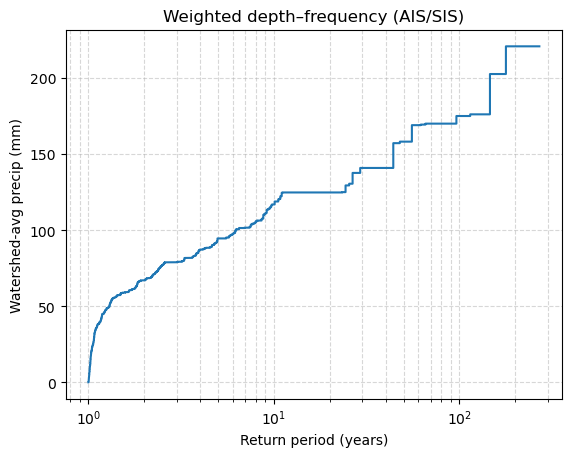

In [145]:
# 3) Build and run adaptive SIS for depths (no refinement version; adapts allocations)
storm_paths = precip_cube.storm_path.values
sampler = AdaptiveDepthSIS(
    domain_gdf=domain_gdf,
    processor=processor,
    storm_paths=precip_cube.storm_path.values,
    target_cells=20,
    pi_floor=1e-3,
    adapt_min_depth_mm=2.0*25.4,
)

# Five iterations with a total of ~280 runs (tune as you like)
n_iters = 10
batch_schedule = [100] * n_iters

# split the top 3 cells after *every* iteration (1..10)
refine_at = {t: 4 for t in range(2, n_iters+1, 1)}

all_samples = sampler.run(
    n_iters=n_iters,
    batch_schedule=batch_schedule,
    blend_area=0.3,
    n_jobs=-1,
    seed=42,
    refine_at={t: 10 for t in range(1, n_iters+1)},
    weight_mode="per_draw",   # <-- SUPER fast
)
# 4) Build weighted exceedance curve and return periods from depths
depth_curve = weighted_ecdf_return_periods(all_samples, arrival_rate=10.0)

# 5) Inspect results
print(all_samples.head())
print(depth_curve.head())

# Optional: quick plot (matplotlib)
import matplotlib.pyplot as plt

plt.figure()
plt.step(depth_curve["RP_years"], depth_curve["precip_avg_mm"], where="post")
plt.xscale("log")
plt.xlabel("Return period (years)")
plt.ylabel("Watershed-avg precip (mm)")
plt.title("Weighted depth–frequency (AIS/SIS)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


   grid_id              x             y           A_c  pi_c  event_id  \
0        1  118767.419213  9.741919e+05  4.598759e+10  0.05  iter1_k0   
1        1  313430.791206  9.792796e+05  4.598759e+10  0.05  iter1_k1   
2        1  294298.808163  8.821537e+05  4.598759e+10  0.05  iter1_k2   
3        1  325043.999703  1.023503e+06  4.598759e+10  0.05  iter1_k3   
4        1  131815.382328  9.600724e+05  4.598759e+10  0.05  iter1_k4   

  storm_path  iter_id  precip_avg_mm        q_draw  is_weight  
0   19821225        1      98.647803  2.487986e-15        1.0  
1   20130108        1      68.318322  2.487986e-15        1.0  
2   20070704        1       0.000000  2.487986e-15        1.0  
3   19980202        1      42.734599  2.487986e-15        1.0  
4   19971221        1      65.979152  2.487986e-15        1.0  
   precip_avg_mm      mass  exc_prob_event    RP_years
0     195.179291  0.000236        0.000236  423.492666
1     190.840175  0.000125        0.000361  277.163820
2     174.05

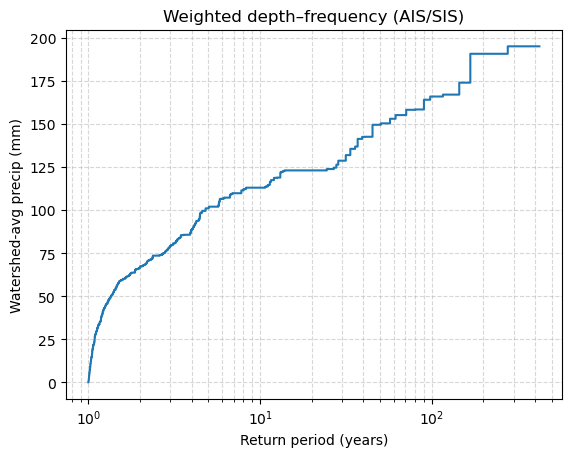

In [130]:
# 5) Inspect results
print(all_samples.head())
print(depth_curve.head())

# Optional: quick plot (matplotlib)
import matplotlib.pyplot as plt

plt.figure()
plt.step(depth_curve["RP_years"], depth_curve["precip_avg_mm"], where="post")
plt.xscale("log")
plt.xlabel("Return period (years)")
plt.ylabel("Watershed-avg precip (mm)")
plt.title("Weighted depth–frequency (AIS/SIS)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [131]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

def make_final_grid_gdf(
    sampler: AdaptiveDepthSIS,
    domain_gdf: gpd.GeoDataFrame,
    compute_pi_view: bool = False,   # display-only; can be slow
    compute_stats: bool = True,
) -> gpd.GeoDataFrame:
    """
    Returns the last-partition grid with useful columns:
    grid_id, level, area_m2, pi, (optional) pi_view, (optional) mean/sigma/n
    """
    final_grid = sampler.partitions[-1].grid.copy()

    # optional display-only probability reconstruction (can be slow)
    if compute_pi_view:
        final_grid["pi_view"] = sampler._reconstruct_cell_pi_from_samples(final_grid)
    else:
        final_grid["pi_view"] = np.nan  # or use final_grid.get("pi", np.nan)

    # weighted stats per cell on the current partition
    if compute_stats:
        stats = sampler._weighted_cell_stats_current_partition(final_grid)
        final_grid = final_grid.merge(stats, on="grid_id", how="left")

    for col in ["mean", "sigma", "n"]:
        if col not in final_grid:
            final_grid[col] = np.nan

    if "level" not in final_grid:
        final_grid["level"] = 1

    # align CRS with domain for plotting
    if final_grid.crs != domain_gdf.crs:
        final_grid = final_grid.to_crs(domain_gdf.crs)
    return final_grid


def plot_grid_domain_watershed(
    final_grid: gpd.GeoDataFrame,
    domain_gdf: gpd.GeoDataFrame,
    watershed_gdf: gpd.GeoDataFrame,
    color_by: str = "level",   # try "sigma", "pi_view", "n", etc.
    fill_watershed: bool = True,
):
    # CRS alignment
    if watershed_gdf.crs != domain_gdf.crs:
        watershed_gdf = watershed_gdf.to_crs(domain_gdf.crs)
    if final_grid.crs != domain_gdf.crs:
        final_grid = final_grid.to_crs(domain_gdf.crs)

    fig, ax = plt.subplots(figsize=(9, 9))

    # domain outline
    domain_gdf.boundary.plot(ax=ax, linewidth=1.2, color="black", zorder=1)

    # grid (underlay so watershed edges are visible)
    edgecolor = "k" if color_by else "k"
    if color_by and color_by in final_grid.columns:
        final_grid.plot(ax=ax, column=color_by, legend=True, linewidth=0.3, edgecolor=edgecolor, zorder=2)
    else:
        final_grid.boundary.plot(ax=ax, linewidth=0.4, color="gray", zorder=2)

    # watershed overlay (fill + edge)
    if fill_watershed:
        watershed_gdf.plot(ax=ax, alpha=0.15, color="tab:red", edgecolor="tab:red", linewidth=1.5, zorder=3)
    else:
        watershed_gdf.boundary.plot(ax=ax, color="tab:red", linewidth=1.8, zorder=3)

    ax.set_aspect("equal")
    ax.set_title(f"Final Grid over Domain with Watershed (colored by '{color_by}')")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    plt.tight_layout()
    plt.show()


In [132]:
sampler.samples_all[["iter_id","event_id","storm_path","x","y","precip_avg_mm","q_draw","is_weight"]]


,iter_id,event_id,storm_path,x,y,precip_avg_mm,q_draw,is_weight
0,1,iter1_k0,19821225,118767.419213,9.741919e+05,98.647803,2.487986e-15,1.000000
1,1,iter1_k1,20130108,313430.791206,9.792796e+05,68.318322,2.487986e-15,1.000000
2,1,iter1_k2,20070704,294298.808163,8.821537e+05,0.000000,2.487986e-15,1.000000
3,1,iter1_k3,19980202,325043.999703,1.023503e+06,42.734599,2.487986e-15,1.000000
4,1,iter1_k4,19971221,131815.382328,9.600724e+05,65.979152,2.487986e-15,1.000000
...,...,...,...,...,...,...,...,...
995,10,iter10_k95,20060509,-103544.502951,1.131052e+06,55.946115,3.360489e-14,0.074036
996,10,iter10_k96,20020123,-120544.263181,1.086770e+06,96.235882,3.360489e-14,0.074036
997,10,iter10_k97,19941006,56797.412215,1.052877e+06,51.183757,1.273849e-13,0.019531
998,10,iter10_k98,20210429,21988.007919,8.855872e+05,73.892056,1.273849e-13,0.019531


In [146]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

def make_final_grid_gdf(
    sampler: AdaptiveDepthSIS,
    domain_gdf: gpd.GeoDataFrame,
    compute_pi_view: bool = False,   # display-only; can be slow
    compute_stats: bool = False,      # not needed for outline-only plotting
) -> gpd.GeoDataFrame:
    final_grid = sampler.partitions[-1].grid.copy()

    if compute_pi_view:
        final_grid["pi_view"] = sampler._reconstruct_cell_pi_from_samples(final_grid)
    else:
        final_grid["pi_view"] = np.nan

    if compute_stats:
        stats = sampler._weighted_cell_stats_current_partition(final_grid)
        final_grid = final_grid.merge(stats, on="grid_id", how="left")

    for col in ["mean", "sigma", "n"]:
        if col not in final_grid:
            final_grid[col] = np.nan

    if "level" not in final_grid:
        final_grid["level"] = 1

    if final_grid.crs != domain_gdf.crs:
        final_grid = final_grid.to_crs(domain_gdf.crs)
    return final_grid


def plot_grid_with_points(
    sampler: AdaptiveDepthSIS,
    domain_gdf: gpd.GeoDataFrame,
    watershed_gdf: gpd.GeoDataFrame,
    final_grid: gpd.GeoDataFrame | None = None,
    which: str = "all",          # "all" | "last_iter"
    tail_mm: float | None = None, # e.g., 2*25.4 to show only ≥2" samples
    max_points: int = 20000,      # subsample for speed if huge
    point_size: float = 6.0,
    point_alpha: float = 0.6,
):
    """
    Plot grid outlines (no color) and sampled points.

    which:
      - "all": all samples collected so far
      - "last_iter": only samples from the final iteration
    tail_mm:
      - if set, only plot samples with precip_avg_mm >= tail_mm
    """
    # Build/align grid
    if final_grid is None:
        final_grid = make_final_grid_gdf(sampler, domain_gdf, compute_pi_view=False, compute_stats=False)

    if watershed_gdf.crs != domain_gdf.crs:
        watershed_gdf = watershed_gdf.to_crs(domain_gdf.crs)
    if final_grid.crs != domain_gdf.crs:
        final_grid = final_grid.to_crs(domain_gdf.crs)

    # Select samples
    samples = sampler.samples_all.copy()
    if samples.empty:
        raise ValueError("sampler.samples_all is empty — run sampler.run(...) first.")

    if which == "last_iter" and "iter_id" in samples.columns:
        last_it = int(samples["iter_id"].max())
        samples = samples.loc[samples["iter_id"] == last_it]

    if tail_mm is not None and "precip_avg_mm" in samples.columns:
        samples = samples.loc[samples["precip_avg_mm"] >= float(tail_mm)]

    # optional downsampling for plotting speed
    if len(samples) > max_points:
        samples = samples.sample(max_points, random_state=0)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(9, 9))

    # Domain outline
    domain_gdf.boundary.plot(ax=ax, linewidth=1.2, color="black", zorder=1)

    # Grid outlines only (no fill, no legend)
    final_grid.boundary.plot(ax=ax, linewidth=0.4, color="gray", zorder=2)

    # Watershed outline (no fill)
    watershed_gdf.boundary.plot(ax=ax, color="red", linewidth=1.5, zorder=3)

    # Sampled points
    ax.scatter(
        samples["x"].to_numpy(),
        samples["y"].to_numpy(),
        s=point_size,
        alpha=point_alpha,
        c="k",
        linewidths=0,
        zorder=4
    )

    ax.set_aspect("equal")
    title_tail = f", tail ≥ {tail_mm:.1f} mm" if tail_mm is not None else ""
    which_txt = "last iter" if which == "last_iter" else "all iters"
    ax.set_title(f"Sampled Points over Final Grid ({which_txt}{title_tail})")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    plt.tight_layout()
    plt.show()


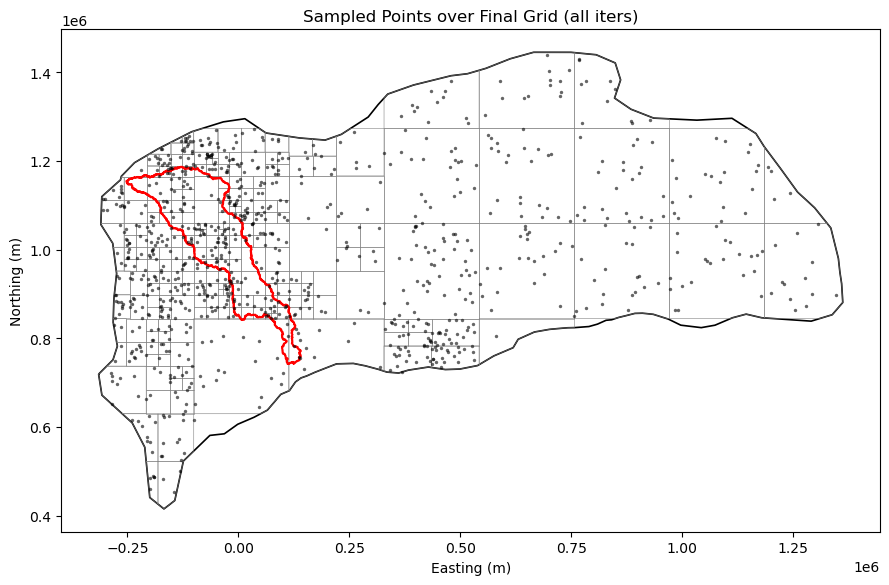

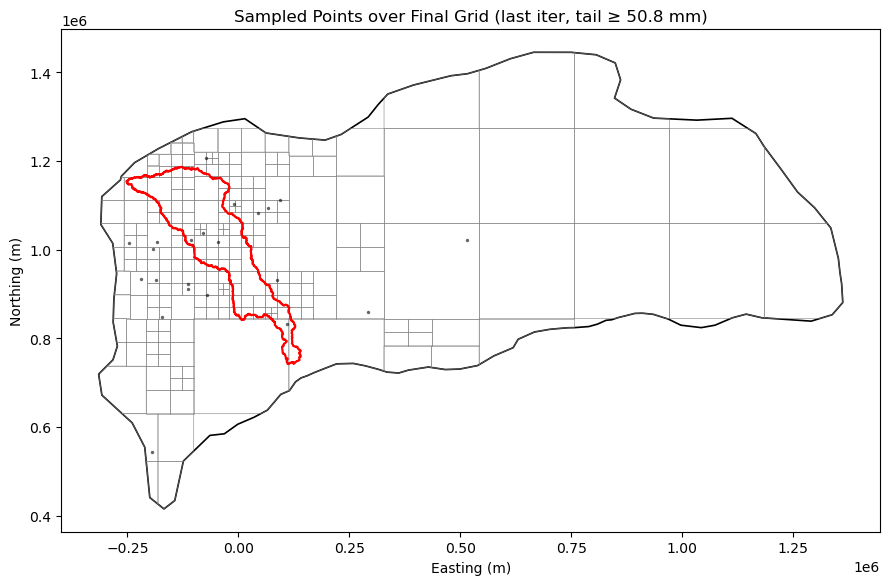

In [147]:
final_grid = make_final_grid_gdf(sampler, domain_gdf, compute_pi_view=False, compute_stats=False)

# All samples, no coloring, just outlines + points
plot_grid_with_points(sampler, domain_gdf, watershed_gdf, final_grid)

# Or only last iteration, and only tail ≥ 2 inches:
plot_grid_with_points(
    sampler, domain_gdf, watershed_gdf, final_grid,
    which="last_iter", tail_mm=2.0*25.4
)


/tmp/ipykernel_4150/2616558058.py:634: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()


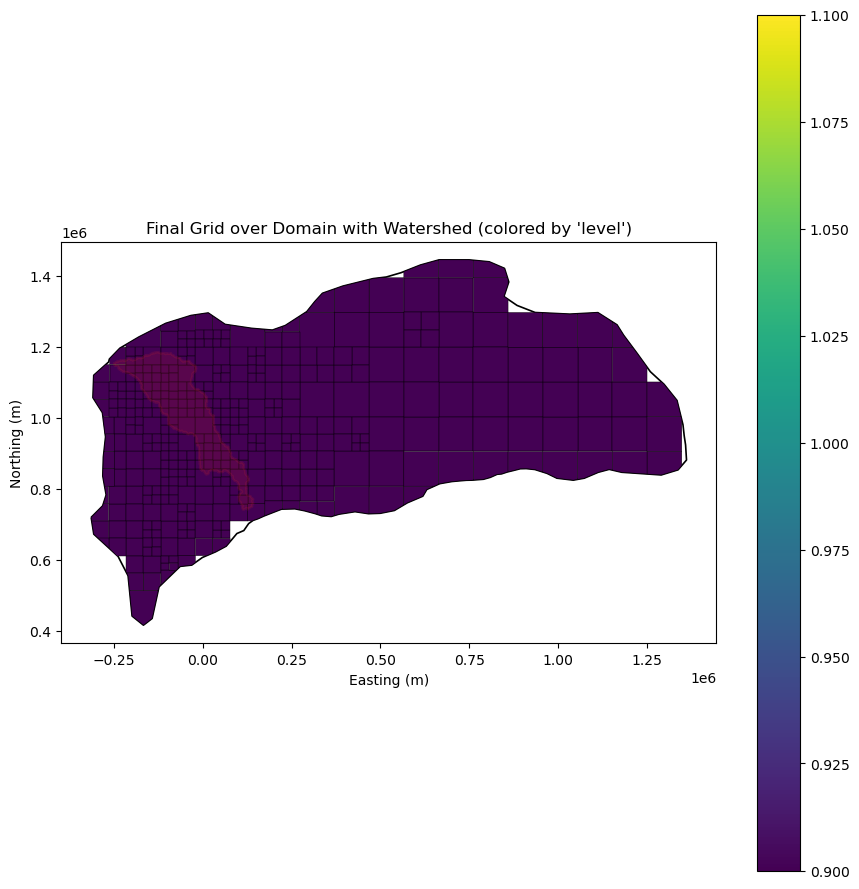

In [101]:
final_grid = make_final_grid_gdf(
    sampler,
    domain_gdf=domain_gdf,
    compute_pi_view=False,   # True if you want that diagnostic (slower)
    compute_stats=True
)

# color by refinement level
plot_grid_domain_watershed(final_grid, domain_gdf, watershed_gdf)#, color_by="level")

# or color by weighted std-deviation of depth (if computed)

In [148]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from affine import Affine
from joblib import Parallel, delayed
from shapely.geometry import Point, Polygon, box, mapping
from shapely.ops import triangulate
from rasterio.features import geometry_mask, rasterize
from shapely.prepared import prep

# ---------------------------
# 0) Small geometry helpers
# ---------------------------

def _cell_size_from_target_cells(domain: gpd.GeoDataFrame, target_cells: int) -> float:
    if domain.crs is None:
        raise ValueError("domain GeoDataFrame must have a projected (equal-area) CRS.")
    A = float(domain.geometry.area.sum())
    A_cell = A / max(target_cells, 1)
    return math.sqrt(A_cell)

def _square_grid_over_bbox(bounds: Tuple[float, float, float, float], cell: float) -> Iterable[Polygon]:
    minx, miny, maxx, maxy = bounds
    xs = np.arange(minx, maxx + cell, cell)
    ys = np.arange(miny, maxy + cell, cell)
    for x in xs[:-1]:
        for y in ys[:-1]:
            yield box(x, y, x + cell, y + cell)

def make_initial_grid(
    domain: gpd.GeoDataFrame,
    target_cells: int = 96,
    sliver_fraction: float = 0.20,
) -> gpd.GeoDataFrame:
    dom = domain[["geometry"]].copy()
    if len(dom) > 1:
        dom = dom.dissolve().reset_index(drop=True)

    cell = _cell_size_from_target_cells(dom, target_cells)
    raw = gpd.GeoDataFrame(geometry=list(_square_grid_over_bbox(dom.total_bounds, cell)), crs=dom.crs)
    grid = gpd.overlay(raw, dom, how="intersection", keep_geom_type=True)
    grid = grid[~grid.is_empty].reset_index(drop=True)

    A_total = float(dom.geometry.area.sum())
    A_cell_mean_preclip = cell * cell
    min_area = sliver_fraction * A_cell_mean_preclip

    grid["area_m2"] = grid.geometry.area
    grid = grid.loc[grid["area_m2"] > min_area].reset_index(drop=True)

    grid.insert(0, "grid_id", np.arange(1, len(grid) + 1, dtype=int))
    grid["level"] = 1
    grid["pi"] = grid["area_m2"] / A_total

    grid = grid.sort_values("area_m2", ascending=False).reset_index(drop=True)
    grid["grid_id"] = np.arange(1, len(grid) + 1, dtype=int)
    return grid

def _sample_point_in_triangle(tri: Polygon) -> Point:
    (x1, y1), (x2, y2), (x3, y3) = np.asarray(tri.exterior.coords)[:3]
    r1, r2 = np.random.rand(2)
    sr1 = math.sqrt(r1)
    u = 1.0 - sr1
    v = sr1 * (1.0 - r2)
    w = sr1 * r2
    return Point(u * x1 + v * x2 + w * x3, u * y1 + v * y2 + w * y3)


def sample_uniform_in_polygon(poly, n: int = 1):
    """
    Robust uniform sampling inside an arbitrary polygon (handles holes, concavity).
    Uses rejection sampling in the polygon's bounding box.
    """
    minx, miny, maxx, maxy = poly.bounds
    prepped = prep(poly)
    pts = []
    need = n

    # oversample batches to keep it efficient
    while need > 0:
        k = max(32, 3 * need)  # batch size
        xs = np.random.uniform(minx, maxx, size=k)
        ys = np.random.uniform(miny, maxy, size=k)
        for x, y in zip(xs, ys):
            p = Point(x, y)
            if prepped.covers(p):   # strictly inside (covers handles boundary nicely)
                pts.append(p)
                need -= 1
                if need == 0:
                    break
    return pts

def _split_cell_into_quads(cell_row: gpd.GeoSeries, crs) -> gpd.GeoDataFrame:
    poly = cell_row.geometry
    minx, miny, maxx, maxy = poly.bounds
    mx = 0.5 * (minx + maxx)
    my = 0.5 * (miny + maxy)

    quads = [
        box(minx, miny, mx,    my),
        box(mx,   miny, maxx,  my),
        box(minx, my,   mx,    maxy),
        box(mx,   my,   maxx,  maxy),
    ]

    geoms = []
    for q in quads:
        piece = poly.intersection(q)
        if not piece.is_empty:
            geoms.append(piece)

    return gpd.GeoDataFrame(geometry=geoms, crs=crs).reset_index(drop=True)

def refine_grid_quadtree(
    grid: gpd.GeoDataFrame,
    stats: pd.DataFrame,
    top_k: int = 3,
    min_child_area_frac: float = 0.05,
    focus_poly: Optional[Polygon] = None,
    min_tail_n: int = 3,
) -> gpd.GeoDataFrame:
    # require sigma
    if stats is None or stats.empty or ("sigma" not in stats.columns):
        return grid.copy()

    g = grid.copy()
    g["geometry"] = g.geometry.buffer(0)

    s = stats.set_index("grid_id")
    merge_cols = [c for c in ["sigma", "n"] if c in s.columns]
    g = g.merge(s[merge_cols], left_on="grid_id", right_index=True, how="left")

    g["sigma"] = g["sigma"].fillna(0.0)
    g["n"] = g.get("n", 0).fillna(0).astype(int)

    if min_tail_n is not None and min_tail_n > 0:
        g = g.loc[g["n"] >= min_tail_n]

    if focus_poly is not None:
        g = g.loc[g.geometry.intersects(focus_poly)]

    if g.empty:
        return grid.copy()

    A_total = float(g["area_m2"].sum())
    g["var_contrib"] = (g["area_m2"] / A_total) ** 2 * (g["sigma"] ** 2)

    to_split = g.sort_values("var_contrib", ascending=False).head(top_k)
    if to_split.empty:
        return grid.copy()

    keep = grid.loc[~grid["grid_id"].isin(to_split["grid_id"])].copy()
    childs = []
    crs0 = grid.crs
    next_level_default = (int(grid["level"].max()) if "level" in grid.columns else 1) + 1

    for _, row in to_split.iterrows():
        parent_area = float(row["area_m2"])
        parent_pi   = float(row["pi"])
        parent_lvl  = int(row["level"]) + 1 if "level" in grid.columns else next_level_default

        kids = _split_cell_into_quads(row, crs=crs0)
        if kids.empty:
            keep = pd.concat([keep, row.to_frame().T], ignore_index=True)
            continue

        kids["area_m2"] = kids.geometry.area
        min_child_area = min_child_area_frac * (parent_area / 4.0)
        kids = kids.loc[kids["area_m2"] >= min_child_area].reset_index(drop=True)
        if kids.empty:
            keep = pd.concat([keep, row.to_frame().T], ignore_index=True)
            continue

        share = kids["area_m2"] / kids["area_m2"].sum()
        kids["pi"] = parent_pi * share
        kids["level"] = parent_lvl
        childs.append(kids[["geometry", "area_m2", "pi", "level"]])

    if not childs:
        return grid.copy()

    children_gdf = pd.concat(childs, ignore_index=True)
    new_grid = pd.concat(
        [keep[["geometry", "area_m2", "pi", "level"]] if "level" in keep.columns else keep[["geometry", "area_m2", "pi"]],
         children_gdf],
        ignore_index=True,
    )
    new_grid["pi"] = new_grid["pi"] / new_grid["pi"].sum()
    new_grid = new_grid.sort_values("area_m2", ascending=False).reset_index(drop=True)
    new_grid.insert(0, "grid_id", np.arange(1, len(new_grid) + 1, dtype=int))
    return new_grid.set_crs(crs0, allow_override=True)


# --------------------------------------------
# 1) Processor for watershed-average precip
# --------------------------------------------

class StormDepthProcessorSimple:
    """
    Given (x,y) and storm_path, compute watershed-average precip after shifting the
    2D field so that its "center" moves to (x,y).
    """
    def __init__(
        self,
        precip_cube: xr.DataArray,         # dims: ('storm_path','y','x')
        storm_centers: pd.DataFrame,       # cols: ['storm_path','x','y']
        watershed_gdf: gpd.GeoDataFrame,
    ) -> None:
        if "storm_path" not in precip_cube.dims:
            raise ValueError("precip_cube must have a 'storm_path' dimension.")

        self.cube = precip_cube
        self.storm_centers = storm_centers.set_index("storm_path")
        self.x_coords = precip_cube.x.values
        self.y_coords = precip_cube.y.values
        self.dx = float(np.mean(np.diff(self.x_coords)))
        self.dy = float(np.mean(np.diff(self.y_coords)))
        self.transform = Affine.translation(self.x_coords[0], self.y_coords[0]) * Affine.scale(self.dx, self.dy)

        self.mask = geometry_mask(
            geometries=[mapping(geom) for geom in watershed_gdf.geometry],
            out_shape=(len(self.y_coords), len(self.x_coords)),
            transform=self.transform,
            invert=True,
        )

    def _shift_and_avg(self, storm_path: str, x_new: float, y_new: float) -> Tuple[float, float, float]:
        # original center
        try:
            x0, y0 = self.storm_centers.loc[storm_path, ["x", "y"]]
        except KeyError:
            return (np.nan, np.nan, np.nan)  # no center info

        dx_cells = int(round((x_new - x0) / self.dx))
        dy_cells = int(round((y_new - y0) / self.dy))

        sp_idx = int(np.where(self.cube.storm_path.values == storm_path)[0][0])
        precip = self.cube.isel(storm_path=sp_idx).values  # 2D (y,x)

        shifted = np.roll(precip, shift=(dy_cells, dx_cells), axis=(0, 1))
        # zero-fill wrapped edges
        if dy_cells > 0: shifted[:dy_cells, :] = 0
        if dy_cells < 0: shifted[dy_cells:, :] = 0
        if dx_cells > 0: shifted[:, :dx_cells] = 0
        if dx_cells < 0: shifted[:, dx_cells:] = 0

        masked = np.where(self.mask, shifted, 0.0)
        masked = np.where(np.isnan(masked), 0.0, masked)
        pavg_mm = float(masked.sum() / self.mask.sum())
        return pavg_mm, float(x0), float(y0)

    def compute_depths(self, samples: pd.DataFrame, n_jobs: int = -1) -> pd.DataFrame:
        tasks = list(zip(
            samples["event_id"].tolist(),
            samples["storm_path"].tolist(),
            samples["x"].tolist(),
            samples["y"].tolist(),
        ))

        def _one(ev_id: str, sp: str, x: float, y: float) -> Dict[str, object]:
            pavg_mm, x0, y0 = self._shift_and_avg(sp, x, y)
            return {"event_id": ev_id, "x0": x0, "y0": y0, "precip_avg_mm": pavg_mm}

        if n_jobs == 1:
            out = [_one(*t) for t in tasks]
        else:
            out = Parallel(n_jobs=n_jobs, prefer="threads")([delayed(_one)(*t) for t in tasks])

        return pd.DataFrame(out)


# ---------------------------------------------------
# 2) Adaptive human-in-the-loop sampler (Consequence)
# ---------------------------------------------------

@dataclass
class Partition:
    grid: gpd.GeoDataFrame
    sindex: object
    areas: Dict[int, float]
    pis: Dict[int, float]

    @classmethod
    def from_grid(cls, grid_gdf: gpd.GeoDataFrame) -> "Partition":
        grid = grid_gdf[["grid_id", "area_m2", "pi", "geometry"]].copy()
        sindex = grid.sindex
        areas = dict(zip(grid["grid_id"], grid["area_m2"].astype(float)))
        pis = dict(zip(grid["grid_id"], grid["pi"].astype(float)))
        return cls(grid=grid, sindex=sindex, areas=areas, pis=pis)

    def locate_cell_id(self, x: float, y: float) -> Optional[int]:
        pt = Point(x, y)
        for idx in list(self.sindex.query(pt)):
            geom = self.grid.iloc[idx].geometry
            if geom.covers(pt):
                return int(self.grid.iloc[idx]["grid_id"])
        return None


class AdaptiveConsequenceSIS:
    """
    Plans spatial transpositions for storms; you run HMS/RAS externally and feed back
    'consequence' per event_id. The sampler then adapts/refines the x–y grid.
    """

    def __init__(
        self,
        domain_gdf: gpd.GeoDataFrame,
        processor: StormDepthProcessorSimple,
        storm_paths: np.ndarray,              # e.g., precip_cube.storm_path.values
        target_cells: int = 96,
        pi_floor: float = 1e-3,
        rng: Optional[np.random.Generator] = None,
        tail_depth_inches: float = 2.0,       # use ≥2 in precip for proxy adaptation until consequence exists
    ) -> None:
        self.domain = domain_gdf[["geometry"]].copy()
        self.grid_t = make_initial_grid(domain_gdf, target_cells=target_cells)
        self.partitions: List[Partition] = [Partition.from_grid(self.grid_t)]
        self.processor = processor
        self.storm_paths = storm_paths
        self.n_storms = int(storm_paths.size)
        self.pi_floor = float(pi_floor)
        self.rng = rng or np.random.default_rng(1234)
        self.tail_depth_mm = float(tail_depth_inches) * 25.4

        # uniform target: p(x,s) = 1/A * 1/|S|
        self.A_total = float(self.domain.geometry.area.sum())
        self.p_storm = 1.0 / self.n_storms
        self.p_target_const = (1.0 / self.A_total) * self.p_storm

        # storage
        self.samples_all: pd.DataFrame = pd.DataFrame()
        self.iter_meta: List[Dict[str, float]] = []

    # ---------- allocation & sampling ----------

    def _allocate_counts(self, n_total: int, weighted_stats: Optional[pd.DataFrame], blend_area: float = 0.3) -> gpd.GeoDataFrame:
        g = self.grid_t[["grid_id", "area_m2", "pi", "geometry"]].copy()
        area = g["area_m2"].to_numpy(float)
        area_prob = area / max(area.sum(), 1e-300)

        use_area_only = (weighted_stats is None) or weighted_stats.empty or ("sigma" not in weighted_stats.columns)
        if not use_area_only:
            s = weighted_stats.set_index("grid_id")
            sig = g["grid_id"].map(s["sigma"]).to_numpy(float)
            sig[~np.isfinite(sig)] = 0.0
            neyman = area * sig
            tot = neyman.sum()
            if tot <= 0 or not np.isfinite(tot):
                use_area_only = True
            else:
                probs = blend_area * area_prob + (1.0 - blend_area) * (neyman / tot)
        if use_area_only:
            probs = area_prob

        probs = np.maximum(np.asarray(probs, float), self.pi_floor)
        probs = probs / probs.sum()

        ideal = probs * n_total
        n_alloc = np.floor(ideal).astype(int)
        short = int(n_total - n_alloc.sum())
        if short > 0:
            frac = ideal - np.floor(ideal)
            n_alloc[np.argsort(-frac)[:short]] += 1

        g["n_alloc"] = n_alloc
        # record realized π for this iteration (used in q_draw)
        g["pi"] = n_alloc / max(n_total, 1)
        return g

    def _sample_points_in_cells(self, grid_alloc: gpd.GeoDataFrame) -> pd.DataFrame:
        rows = []
        for _, r in grid_alloc.iterrows():
            n = int(r["n_alloc"])
            if n <= 0:
                continue
            pts = sample_uniform_in_polygon(r.geometry, n=n)
            for p in pts:
                rows.append({
                    "grid_id": int(r["grid_id"]),
                    "x": float(p.x),
                    "y": float(p.y),
                    "A_c": float(r["area_m2"]),
                    "pi_c": float(r["pi"]),
                })
        return pd.DataFrame(rows)

    # ---------- proposal & weights ----------

    def _q_iter_point(self, part: Partition, x: float, y: float) -> float:
        gid = part.locate_cell_id(x, y)
        if gid is None:
            return 0.0
        return part.pis[gid] * (1.0 / part.areas[gid]) * self.p_storm

    def _qbar(self, coords: np.ndarray) -> np.ndarray:
        N = coords.shape[0]
        n_per_iter = np.array([m["n_total"] for m in self.iter_meta], dtype=float)
        wts = n_per_iter / max(n_per_iter.sum(), 1e-300)
        qsum = np.zeros(N, dtype=float)
        for w, part in zip(wts, self.partitions):
            q_t = np.array([self._q_iter_point(part, coords[i, 0], coords[i, 1]) for i in range(N)], dtype=float)
            qsum += w * q_t
        return qsum

    def _compute_weights(self, weight_mode: str) -> None:
        EPS = np.finfo(float).tiny
        if self.samples_all.empty:
            return
        if weight_mode.lower() == "per_draw":
            qd = np.clip(self.samples_all["q_draw"].to_numpy(), EPS, None)
            self.samples_all["is_weight"] = self.p_target_const / qd
        elif weight_mode.lower() == "amis":
            coords = self.samples_all[["x", "y"]].to_numpy()
            qbar = np.clip(self._qbar(coords), EPS, None)
            self.samples_all["is_weight"] = self.p_target_const / qbar
        else:
            raise ValueError("weight_mode must be 'amis' or 'per_draw'")

    # ---------- diagnostics & stats ----------

    def _weighted_cell_stats(self, metric_col: str) -> pd.DataFrame:
        """
        Weighted mean/std per cell of `metric_col` for the *current grid*.
        Uses only tail precip (≥ tail_depth_mm) when metric is precip and consequence is not yet available.
        """
        if self.samples_all.empty or metric_col not in self.samples_all:
            return pd.DataFrame()

        part = Partition.from_grid(self.grid_t)
        gids = []
        for _, r in self.samples_all.iterrows():
            gid = part.locate_cell_id(float(r["x"]), float(r["y"]))
            gids.append(gid)

        df = self.samples_all.copy()
        df["grid_id_current"] = gids
        df = df.dropna(subset=["grid_id_current", metric_col])
        if df.empty:
            return pd.DataFrame()

        # For precip proxy, keep tail (≥ 2 in) to aim refinement where impactful
        if metric_col == "precip_avg_mm":
            df = df.loc[df["precip_avg_mm"] >= self.tail_depth_mm]
            if df.empty:
                return pd.DataFrame()

        df["grid_id_current"] = df["grid_id_current"].astype(int)

        def _wstats(sub: pd.DataFrame) -> Tuple[float, float, int]:
            w = sub["is_weight"].to_numpy()
            y = sub[metric_col].to_numpy()
            W = max(w.sum(), 1e-300)
            mu = float(np.sum(w * y) / W)
            var = float(np.sum(w * (y - mu) ** 2) / W)
            return (mu, math.sqrt(max(var, 0.0)), len(sub))

        stats = (
            df.groupby("grid_id_current", group_keys=False)
              .apply(_wstats).apply(pd.Series).reset_index()
              .rename(columns={"grid_id_current": "grid_id", 0: "mean", 1: "sigma", 2: "n"})
        )
        return stats

    # ---------- public: one iteration plan ----------

    def plan_one_iteration(
        self,
        iter_id: int,
        n_total: int,
        blend_area: float = 0.3,
        n_jobs: int = -1,
        seed: Optional[int] = None,
        weight_mode: str = "per_draw",
    ) -> pd.DataFrame:
        """
        Returns a DataFrame (= RUN PLAN) with one row per draw:
          event_id, iter_id, storm_path, x_new, y_new, x0, y0, dx_m, dy_m,
          precip_avg_mm, precip_avg_in, grid_id, q_draw, pi_c, A_c
        You run HMS/RAS, compute 'consequence' per event_id externally, then call ingest_feedback().
        """
        if seed is not None:
            np.random.seed(seed)
            self.rng = np.random.default_rng(seed)

        # Allocation (use consequence if present; else precip proxy)
        metric_col = "consequence" if ("consequence" in self.samples_all.columns and self.samples_all["consequence"].notna().any()) else "precip_avg_mm"
        stats = self._weighted_cell_stats(metric_col=metric_col)

        grid_alloc = self._allocate_counts(n_total=n_total, weighted_stats=stats, blend_area=blend_area)
        pts_df = self._sample_points_in_cells(grid_alloc)
        if pts_df.empty:
            raise RuntimeError("No points were allocated; check inputs.")

        # choose storms uniformly
        storms = self.rng.choice(self.storm_paths, size=len(pts_df), replace=True)

        # build sample batch
        pts_df = pts_df.assign(
            event_id=[f"iter{iter_id}_k{k}" for k in range(len(pts_df))],
            storm_path=storms,
            iter_id=iter_id,
        )

        # compute precip for run planning
        depths_df = self.processor.compute_depths(
            samples=pts_df[["event_id", "x", "y", "storm_path"]],
            n_jobs=n_jobs,
        )
        out_t = pts_df.merge(depths_df, on="event_id", how="left", validate="one_to_one")

        # useful offsets
        out_t["dx_m"] = out_t["x"] - out_t["x0"]
        out_t["dy_m"] = out_t["y"] - out_t["y0"]
        out_t["precip_avg_in"] = out_t["precip_avg_mm"] / 25.4

        # proposal density used at draw time
        out_t["q_draw"] = (out_t["pi_c"] / out_t["A_c"]) * self.p_storm

        # append to master table (consequence to be ingested later)
        self.iter_meta.append({"iter": iter_id, "n_total": int(n_total)})
        self.samples_all = pd.concat([self.samples_all, out_t], ignore_index=True)

        # weights for all draws so far (don’t depend on consequence)
        self._compute_weights(weight_mode=weight_mode)

        # return the plan rows for THIS iteration only
        cols = [
            "event_id","iter_id","storm_path",
            "x0","y0","x","y","dx_m","dy_m",
            "precip_avg_mm","precip_avg_in",
            "grid_id","pi_c","A_c","q_draw"
        ]
        return out_t[cols].copy()

    def export_run_plan(self, plan_df: pd.DataFrame, path: str) -> None:
        plan_df.to_csv(path, index=False)

    def ingest_feedback(self, results_df: pd.DataFrame, value_col: str = "consequence") -> None:
        """
        Merge external results back by event_id. `results_df` must have columns:
         - event_id
         - value_col (default 'consequence')
        """
        if "event_id" not in results_df.columns:
            raise ValueError("results_df must include 'event_id'.")
        if value_col not in results_df.columns:
            raise ValueError(f"results_df must include '{value_col}'.")

        results_df = results_df[["event_id", value_col]].copy()
        self.samples_all = self.samples_all.merge(results_df, on="event_id", how="left")

    def refine(self, top_k: int = 3, focus_poly: Optional[Polygon] = None, min_tail_n: int = 3) -> None:
        """
        Refine the current grid using the most informative metric available:
        prefers 'consequence' if present; otherwise uses precip tail.
        """
        metric_col = "consequence" if ("consequence" in self.samples_all.columns and self.samples_all["consequence"].notna().any()) else "precip_avg_mm"
        stats = self._weighted_cell_stats(metric_col=metric_col)
        new_grid = refine_grid_quadtree(
            grid=self.grid_t,
            stats=stats,
            top_k=top_k,
            min_child_area_frac=0.05,
            focus_poly=focus_poly,
            min_tail_n=min_tail_n,
        )
        # Only update if changed
        if len(new_grid) != len(self.grid_t):
            self.grid_t = new_grid
        # keep proposal history aligned with iterations
        self.partitions.append(Partition.from_grid(self.grid_t))

    # ---------- curves ----------

    def exceedance_curve(self, value_col: str, arrival_rate: float = 10.0) -> pd.DataFrame:
        """
        Build an IS-weighted exceedance curve for any metric you've stored
        (e.g., 'consequence' or 'precip_avg_mm').
        """
        df = self.samples_all
        if df.empty or value_col not in df.columns:
            return pd.DataFrame(columns=[value_col, "mass", "exc_prob_event", "RP_years"])

        d = df[[value_col, "is_weight"]].dropna().sort_values(value_col, ascending=False).reset_index(drop=True)
        if d.empty:
            return pd.DataFrame(columns=[value_col, "mass", "exc_prob_event", "RP_years"])

        w = d["is_weight"].to_numpy()
        mass = w / w.sum()

        exc_prob_event = np.cumsum(mass)
        P_annual = 1.0 - np.exp(-arrival_rate * exc_prob_event)
        RP_years = 1.0 / np.clip(P_annual, 1e-12, None)

        return pd.DataFrame({
            value_col: d[value_col].to_numpy(),
            "mass": mass,
            "exc_prob_event": exc_prob_event,
            "RP_years": RP_years,
        })


# ---------------------------
# 3) Helper to extract final grid for plotting/saving
# ---------------------------

def make_final_grid_gdf(
    sampler: AdaptiveConsequenceSIS,
    compute_stats_on: str = "consequence",    # or 'precip_avg_mm'
) -> gpd.GeoDataFrame:
    g = sampler.grid_t.copy()
    stats = sampler._weighted_cell_stats(metric_col=compute_stats_on) if compute_stats_on else None
    if stats is not None and not stats.empty:
        g = g.merge(stats, on="grid_id", how="left")
    else:
        for c in ["mean", "sigma", "n"]:
            g[c] = np.nan
    return g


In [154]:
from pathlib import Path

# Inputs you already have from your preprocessor
precip_cube = trinity.cumulative_precip           # dims: ('storm_path','y','x')
storm_centers = trinity.storm_centers             # storm_path, x, y
watershed_gdf = trinity.watershed_gdf
domain_gdf = trinity.domain_gdf

processor = StormDepthProcessorSimple(
    precip_cube=precip_cube,
    storm_centers=storm_centers,
    watershed_gdf=watershed_gdf,
)

sampler = AdaptiveConsequenceSIS(
    domain_gdf=domain_gdf,
    processor=processor,
    storm_paths=precip_cube.storm_path.values,
    target_cells=40,
    pi_floor=1e-3,
    tail_depth_inches=2.0,   # adapt using precip tail until consequence is available
)

TOTAL_BUDGET = 500
N_ITERS = 5
BATCH = TOTAL_BUDGET // N_ITERS  # e.g., 100 per iteration

for t in range(1, N_ITERS + 1):
    # 1) PLAN: you get storm, new center, offsets, precip proxy
    plan_df = sampler.plan_one_iteration(
        iter_id=t,
        n_total=BATCH,
        blend_area=0.3,
        n_jobs=-1,
        seed=42 + t,          # deterministic if you like
        weight_mode="per_draw"
    )
    # optional: write CSV for your HMS/RAS runs
    outdir = Path("./data/1_interim/Denton")
    sampler.export_run_plan(plan_df, outdir / f"run_plan_iter{t}.csv")

    # 2) YOU run HMS/RAS manually for each event_id in plan_df
    #    and prepare a results CSV with columns: event_id, consequence
    #    For illustration, load them back:
    # results_iter_t = pd.read_csv(f"consequence_results_iter{t}.csv")

    # 3) Feed back to sampler (uncomment when you have results)
    # sampler.ingest_feedback(results_iter_t, value_col="consequence")

    # 4) Refine grid for next iteration (uses consequence if available, else precip tail)
    sampler.refine(top_k=3, min_tail_n=3)

# After all iterations (and after you've ingested all consequences):
curve = sampler.exceedance_curve(value_col="consequence", arrival_rate=10.0)
print(curve.head())


/tmp/ipykernel_4150/2369125496.py:467: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()
/tmp/ipykernel_4150/2369125496.py:467: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()
/tmp/ipykernel_4150/2369125496.py:467: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future 

Empty DataFrame
Columns: [consequence, mass, exc_prob_event, RP_years]
Index: []


/tmp/ipykernel_4150/2369125496.py:467: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()
/tmp/ipykernel_4150/2369125496.py:467: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wstats).apply(pd.Series).reset_index()


In [155]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

def plot_grid_and_samples_for_iter(
    sampler,
    iter_id: int = 1,
    domain_gdf: gpd.GeoDataFrame | None = None,
    watershed_gdf: gpd.GeoDataFrame | None = None,
    figsize=(9, 9),
    point_size=10,
):
    """
    Plot the grid used for a given iteration and the sampled (x,y) points from that iteration.
    The grid used to generate draws of iteration t is sampler.partitions[t-1].grid.
    """
    # 1) grid used at this iteration
    grid = sampler.partitions[iter_id - 1].grid
    crs = grid.crs

    # 2) samples from this iteration
    if sampler.samples_all.empty or "iter_id" not in sampler.samples_all.columns:
        raise ValueError("No samples recorded. Run the sampler first.")
    pts_df = sampler.samples_all.loc[sampler.samples_all["iter_id"] == iter_id, ["x", "y"]]
    if pts_df.empty:
        raise ValueError(f"No samples found for iter_id={iter_id}.")

    pts = gpd.GeoDataFrame(
        pts_df.copy(),
        geometry=[Point(xy) for xy in zip(pts_df["x"], pts_df["y"])],
        crs=crs,
    )

    # 3) CRS align
    if domain_gdf is not None and domain_gdf.crs != crs:
        domain_gdf = domain_gdf.to_crs(crs)
    if watershed_gdf is not None and watershed_gdf.crs != crs:
        watershed_gdf = watershed_gdf.to_crs(crs)

    # 4) plot
    fig, ax = plt.subplots(figsize=figsize)
    if domain_gdf is not None:
        domain_gdf.boundary.plot(ax=ax, color="black", linewidth=1.0, zorder=1, label="Domain")
    grid.boundary.plot(ax=ax, color="0.5", linewidth=0.4, zorder=2, label="Grid")
    pts.plot(ax=ax, markersize=point_size, color="black", alpha=0.85, zorder=3, label="Samples")
    if watershed_gdf is not None:
        watershed_gdf.boundary.plot(ax=ax, color="tab:red", linewidth=1.5, zorder=4, label="Watershed")

    ax.set_aspect("equal")
    ax.set_title(f"Iteration {iter_id}: grid and sampled points")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


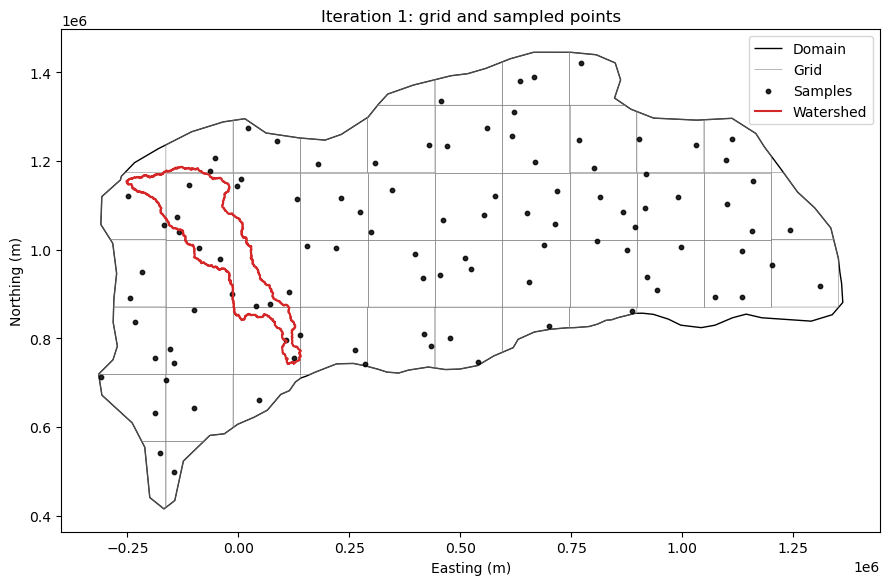

In [156]:
plot_grid_and_samples_for_iter(sampler, iter_id=1,
                               domain_gdf=domain_gdf,
                               watershed_gdf=watershed_gdf)

In [153]:
trinity.storm_centers

,storm_path,x,y
0,19790222,484000.0,908000.0
1,19790302,744000.0,832000.0
2,19790402,812000.0,1028000.0
3,19790411,640000.0,1136000.0
4,19790421,448000.0,788000.0
...,...,...,...
432,20220524,860000.0,852000.0
433,20220822,-124000.0,1068000.0
434,20221124,80000.0,1132000.0
435,20221213,484000.0,936000.0
